In [1]:
"""
Train convex LassoNet models on a synthetic classification dataset using conve|x optimization.
"""

import sys
sys.path.append("..")

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from convex_nn.private.utils.data import gen_classification_data


from convex_nn.models import ConvexGatedReLU, ConvexReLU
from convex_nn.solvers import RFISTA, AL, LeastSquaresSolver, CVXPYSolver
from convex_nn.regularizers import NeuronGL1, L2, L1
from convex_nn.metrics import Metrics
from convex_nn.activations import sample_gate_vectors
from convex_nn.optimize import optimize_model, optimize

In [3]:
# Generate realizable synthetic classification problem (ie. Figure 1)
n_train = 1000
n_test = 1000
d = 50
hidden_units = 100
kappa = 10  # condition number

(X_train, y_train), (X_test, y_test) = gen_classification_data(123, n_train, n_test, d, hidden_units, kappa)

In [4]:
lam = 0.001
max_neurons = 500

In [5]:
model, metrics = optimize("gated_relu", 
                          max_neurons, 
                          X_train, 
                          y_train, 
                          X_test, 
                          y_test,
                          regularizer = NeuronGL1(0.01),
                          verbose=True,  
                          device="cpu")

INFO:convex_nn:Pre-Optimization Metrics: Train Set objective: 0.5, Train Set grad_norm: 0.007702792529016733, 


fista:   0%|          | 0/10000 [00:00<?, ?it/s]

INFO:convex_nn:Termination criterion satisfied at iteration 20/10000. Exiting optimization loop.
INFO:convex_nn:Post-Optimization Metrics: Train Set objective: 0.4586989536285401, Train Set grad_norm: 9.152432767223218e-07, 


Train Set objective: 0.5, Train Set grad_norm: 0.007702792529016733, 


In [6]:
# Instantiate convex model and other options.
G = sample_gate_vectors(np.random.default_rng(123), d, max_neurons)
model = ConvexGatedReLU(G)
solver = RFISTA(model, tol=1e-8)
regularizer = NeuronGL1(0.01)
metrics = Metrics(metric_freq=25, model_loss=True, train_accuracy=True, train_mse=True, test_mse=True, test_accuracy=True, neuron_sparsity=True)

In [7]:
grelu_model, grelu_metrics = optimize_model(
    model,
    solver,
    metrics,
    X_train, 
    y_train, 
    X_test, 
    y_test,
    regularizer=L2(0.001),
    verbose=True,
)

INFO:convex_nn:Pre-Optimization Metrics: Train Set objective: 0.5, Train Set grad_norm: 0.09645780175924301, Train Set base_objective: 0.5, Train Set accuracy: 0.0, Train Set nc_squared_error: 0.5, Test Set nc_accuracy: 0.0, Test Set squared_error: 0.5, group_sparsity: 1.0, 


fista:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.5, Train Set grad_norm: 0.09645780175924301, Train Set base_objective: 0.5, Train Set accuracy: 0.0, Train Set nc_squared_error: 0.5, Test Set nc_accuracy: 0.0, Test Set squared_error: 0.5, group_sparsity: 1.0, 
Train Set objective: 0.024476349353790283, Train Set grad_norm: 9.197350664180703e-06, Train Set base_objective: 0.024476349353790283, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.003871481418609619, Test Set nc_accuracy: 0.934, Test Set squared_error: 0.11726786804199218, group_sparsity: 0.0, 


INFO:convex_nn:Termination criterion satisfied at iteration 51/10000. Exiting optimization loop.
INFO:convex_nn:Post-Optimization Metrics: Train Set objective: 0.023809797286987306, Train Set grad_norm: 9.665082068011088e-09, Train Set base_objective: 0.023809797286987306, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.004664318084716797, Test Set nc_accuracy: 0.936, Test Set squared_error: 0.11564991760253907, group_sparsity: 0.0, 


Train Set objective: 0.023810088634490967, Train Set grad_norm: 1.243412484086548e-08, Train Set base_objective: 0.023810088634490967, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.004674040317535401, Test Set nc_accuracy: 0.936, Test Set squared_error: 0.11564414978027343, group_sparsity: 0.0, 


In [8]:
# Training Accuracy
np.sum(np.sign(grelu_model(X_train)) == y_train) / len(y_train)

1.0

In [9]:
model = ConvexReLU(G)
solver = AL(model      )
metrics = Metrics(metric_freq=25, model_loss=True, train_accuracy=True, train_mse=True, test_mse=True, test_accuracy=True, neuron_sparsity=True)
relu_model, relu_metrics = optimize_model(
    model,
    solver,
    metrics,
    X_train, 
    y_train, 
    X_test, 
    y_test,
    regularizer,
    verbose=True,
)

INFO:convex_nn:Pre-Optimization Metrics: Train Set objective: 0.5, Train Set grad_norm: 0.01577875018119812, Train Set base_objective: 0.5, Train Set accuracy: 0.0, Train Set nc_squared_error: 0.5, Test Set nc_accuracy: 0.0, Test Set squared_error: 0.5, group_sparsity: 1.0, 


Outer al:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.5, Train Set grad_norm: 0.01577875018119812, Train Set base_objective: 0.5, Train Set accuracy: 0.0, Train Set nc_squared_error: 0.5, Test Set nc_accuracy: 0.0, Test Set squared_error: 0.5, group_sparsity: 1.0, 


INFO:convex_nn:*Inner* termination criterion satisfied at iteration 6/10000. Exiting *inner* optimization loop.


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.4770087515804916, Train Set grad_norm: 0.0007291387300938368, Train Set base_objective: 0.4744866981506347, Train Set accuracy: 0.949, Train Set nc_squared_error: 0.38528195190429687, Test Set nc_accuracy: 0.918, Test Set squared_error: 0.39804763793945314, group_sparsity: 0.01, 
Train Set objective: 0.47004539415054025, Train Set grad_norm: 1.389190128975315e-05, Train Set base_objective: 0.46671931457519533, Train Set accuracy: 0.918, Train Set nc_squared_error: 0.3328005981445312, Test Set nc_accuracy: 0.914, Test Set squared_error: 0.35427752685546876, group_sparsity: 0.312, 
Train Set objective: 0.4684321279954165, Train Set grad_norm: 4.160646312811878e-06, Train Set base_objective: 0.4653919849395752, Train Set accuracy: 0.917, Train Set nc_squared_error: 0.3269974365234375, Test Set nc_accuracy: 0.914, Test Set squared_error: 0.34932110595703125, group_sparsity: 0.429, 
Train Set objective: 0.46785923153720793, Train Set grad_norm: 1.4887848465150455e-06,

INFO:convex_nn:*Inner* termination criterion satisfied at iteration 87/10000. Exiting *inner* optimization loop.


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.4677541820295155, Train Set grad_norm: 9.990783382818336e-07, Train Set base_objective: 0.4651372470855713, Train Set accuracy: 0.918, Train Set nc_squared_error: 0.3253385314941406, Test Set nc_accuracy: 0.914, Test Set squared_error: 0.34781655883789064, group_sparsity: 0.503, 


INFO:convex_nn:*Inner* termination criterion satisfied at iteration 20/10000. Exiting *inner* optimization loop.


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.4741251643896103, Train Set grad_norm: 8.900809120859776e-07, Train Set base_objective: 0.46843293571472167, Train Set accuracy: 0.911, Train Set nc_squared_error: 0.3320885009765625, Test Set nc_accuracy: 0.914, Test Set squared_error: 0.352185302734375, group_sparsity: 0.357, 


INFO:convex_nn:*Inner* termination criterion satisfied at iteration 21/10000. Exiting *inner* optimization loop.


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.4783499028906226, Train Set grad_norm: 8.961499133874895e-07, Train Set base_objective: 0.4699790573120117, Train Set accuracy: 0.911, Train Set nc_squared_error: 0.33638485717773436, Test Set nc_accuracy: 0.914, Test Set squared_error: 0.35529580688476564, group_sparsity: 0.3, 
Train Set objective: 0.4815495088100433, Train Set grad_norm: 1.0513606412132503e-06, Train Set base_objective: 0.471008695602417, Train Set accuracy: 0.911, Train Set nc_squared_error: 0.339202880859375, Test Set nc_accuracy: 0.914, Test Set squared_error: 0.35738232421875, group_sparsity: 0.264, 


INFO:convex_nn:*Inner* termination criterion satisfied at iteration 33/10000. Exiting *inner* optimization loop.


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.481474755436182, Train Set grad_norm: 9.593796903573093e-07, Train Set base_objective: 0.4710043315887451, Train Set accuracy: 0.911, Train Set nc_squared_error: 0.33914389038085935, Test Set nc_accuracy: 0.914, Test Set squared_error: 0.3573271484375, group_sparsity: 0.267, 
Train Set objective: 0.48382180171459915, Train Set grad_norm: 1.2035335430482519e-06, Train Set base_objective: 0.47169831848144533, Train Set accuracy: 0.911, Train Set nc_squared_error: 0.34069281005859375, Test Set nc_accuracy: 0.914, Test Set squared_error: 0.35848638916015624, group_sparsity: 0.269, 


INFO:convex_nn:*Inner* termination criterion satisfied at iteration 41/10000. Exiting *inner* optimization loop.


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.4836718322262168, Train Set grad_norm: 9.56335725277313e-07, Train Set base_objective: 0.47170243072509765, Train Set accuracy: 0.911, Train Set nc_squared_error: 0.340500244140625, Test Set nc_accuracy: 0.914, Test Set squared_error: 0.35830581665039063, group_sparsity: 0.348, 


INFO:convex_nn:*Inner* termination criterion satisfied at iteration 26/10000. Exiting *inner* optimization loop.


Train Set objective: 0.4852829897105694, Train Set grad_norm: 1.1754187880796962e-06, Train Set base_objective: 0.4721713275909424, Train Set accuracy: 0.911, Train Set nc_squared_error: 0.34126699829101564, Test Set nc_accuracy: 0.914, Test Set squared_error: 0.3587003173828125, group_sparsity: 0.258, 


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.48527656151354315, Train Set grad_norm: 9.967268397303997e-07, Train Set base_objective: 0.47217759704589846, Train Set accuracy: 0.911, Train Set nc_squared_error: 0.34121148681640623, Test Set nc_accuracy: 0.914, Test Set squared_error: 0.35877127075195314, group_sparsity: 0.321, 


INFO:convex_nn:*Inner* termination criterion satisfied at iteration 5/10000. Exiting *inner* optimization loop.


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.4865419404655695, Train Set grad_norm: 9.836682011155062e-07, Train Set base_objective: 0.47236675453186033, Train Set accuracy: 0.911, Train Set nc_squared_error: 0.34171481323242187, Test Set nc_accuracy: 0.914, Test Set squared_error: 0.35907183837890627, group_sparsity: 0.254, 


INFO:convex_nn:*Inner* termination criterion satisfied at iteration 5/10000. Exiting *inner* optimization loop.


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.4876889780685306, Train Set grad_norm: 9.874599982140353e-07, Train Set base_objective: 0.47265362167358405, Train Set accuracy: 0.911, Train Set nc_squared_error: 0.3417481384277344, Test Set nc_accuracy: 0.914, Test Set squared_error: 0.35914361572265624, group_sparsity: 0.375, 


INFO:convex_nn:*Inner* termination criterion satisfied at iteration 6/10000. Exiting *inner* optimization loop.


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.4886148032546044, Train Set grad_norm: 9.989561249312828e-07, Train Set base_objective: 0.47285716056823734, Train Set accuracy: 0.911, Train Set nc_squared_error: 0.3422317199707031, Test Set nc_accuracy: 0.914, Test Set squared_error: 0.35946160888671874, group_sparsity: 0.252, 


INFO:convex_nn:*Inner* termination criterion satisfied at iteration 7/10000. Exiting *inner* optimization loop.


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.48936970745027064, Train Set grad_norm: 9.364454172100523e-07, Train Set base_objective: 0.47304869842529296, Train Set accuracy: 0.911, Train Set nc_squared_error: 0.3423989562988281, Test Set nc_accuracy: 0.914, Test Set squared_error: 0.3596106872558594, group_sparsity: 0.402, 


INFO:convex_nn:*Inner* termination criterion satisfied at iteration 6/10000. Exiting *inner* optimization loop.


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.48995507855713366, Train Set grad_norm: 9.317296871813596e-07, Train Set base_objective: 0.4731782169342041, Train Set accuracy: 0.911, Train Set nc_squared_error: 0.34257815551757814, Test Set nc_accuracy: 0.914, Test Set squared_error: 0.35973431396484373, group_sparsity: 0.293, 


INFO:convex_nn:*Inner* termination criterion satisfied at iteration 7/10000. Exiting *inner* optimization loop.


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

INFO:convex_nn:*Inner* termination criterion satisfied at iteration 0/10000. Exiting *inner* optimization loop.


Train Set objective: 0.49039992643892766, Train Set grad_norm: 8.121835435304092e-07, Train Set base_objective: 0.47330607986450196, Train Set accuracy: 0.911, Train Set nc_squared_error: 0.34263015747070313, Test Set nc_accuracy: 0.914, Test Set squared_error: 0.35978305053710935, group_sparsity: 0.777, 


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

INFO:convex_nn:*Inner* termination criterion satisfied at iteration 2/10000. Exiting *inner* optimization loop.


Train Set objective: 0.49039992643892766, Train Set grad_norm: 8.121835435304092e-07, Train Set base_objective: 0.47330607986450196, Train Set accuracy: 0.911, Train Set nc_squared_error: 0.34263015747070313, Test Set nc_accuracy: 0.914, Test Set squared_error: 0.35978305053710935, group_sparsity: 0.777, 


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.49110664555430417, Train Set grad_norm: 8.749637459004589e-07, Train Set base_objective: 0.4733848323822022, Train Set accuracy: 0.911, Train Set nc_squared_error: 0.3426178894042969, Test Set nc_accuracy: 0.914, Test Set squared_error: 0.35975439453125, group_sparsity: 0.9, 


INFO:convex_nn:*Inner* termination criterion satisfied at iteration 2/10000. Exiting *inner* optimization loop.


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.49139140574634077, Train Set grad_norm: 9.738503194967052e-07, Train Set base_objective: 0.473437162399292, Train Set accuracy: 0.911, Train Set nc_squared_error: 0.3425177307128906, Test Set nc_accuracy: 0.914, Test Set squared_error: 0.3596563720703125, group_sparsity: 0.936, 


INFO:convex_nn:*Inner* termination criterion satisfied at iteration 4/10000. Exiting *inner* optimization loop.


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

INFO:convex_nn:*Inner* termination criterion satisfied at iteration 0/10000. Exiting *inner* optimization loop.


Train Set objective: 0.4916161334067583, Train Set grad_norm: 7.7156153110991e-07, Train Set base_objective: 0.47349134254455566, Train Set accuracy: 0.911, Train Set nc_squared_error: 0.34224462890625, Test Set nc_accuracy: 0.914, Test Set squared_error: 0.35940826416015625, group_sparsity: 0.949, 


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

INFO:convex_nn:*Inner* termination criterion satisfied at iteration 0/10000. Exiting *inner* optimization loop.


Train Set objective: 0.4916161334067583, Train Set grad_norm: 7.7156153110991e-07, Train Set base_objective: 0.47349134254455566, Train Set accuracy: 0.911, Train Set nc_squared_error: 0.34224462890625, Test Set nc_accuracy: 0.914, Test Set squared_error: 0.35940826416015625, group_sparsity: 0.949, 


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

INFO:convex_nn:*Inner* termination criterion satisfied at iteration 1/10000. Exiting *inner* optimization loop.


Train Set objective: 0.4916161334067583, Train Set grad_norm: 7.7156153110991e-07, Train Set base_objective: 0.47349134254455566, Train Set accuracy: 0.911, Train Set nc_squared_error: 0.34224462890625, Test Set nc_accuracy: 0.914, Test Set squared_error: 0.35940826416015625, group_sparsity: 0.949, 


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.4922027385234833, Train Set grad_norm: 9.320719982497394e-07, Train Set base_objective: 0.4735467529296875, Train Set accuracy: 0.911, Train Set nc_squared_error: 0.34224407958984376, Test Set nc_accuracy: 0.914, Test Set squared_error: 0.359399658203125, group_sparsity: 0.954, 


INFO:convex_nn:*Inner* termination criterion satisfied at iteration 3/10000. Exiting *inner* optimization loop.


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

INFO:convex_nn:*Inner* termination criterion satisfied at iteration 0/10000. Exiting *inner* optimization loop.


Train Set objective: 0.49235593038797376, Train Set grad_norm: 7.957453931339842e-07, Train Set base_objective: 0.47358937072753904, Train Set accuracy: 0.911, Train Set nc_squared_error: 0.34210430908203127, Test Set nc_accuracy: 0.914, Test Set squared_error: 0.359267333984375, group_sparsity: 0.958, 


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.49235593038797376, Train Set grad_norm: 7.957453931339842e-07, Train Set base_objective: 0.47358937072753904, Train Set accuracy: 0.911, Train Set nc_squared_error: 0.34210430908203127, Test Set nc_accuracy: 0.914, Test Set squared_error: 0.359267333984375, group_sparsity: 0.958, 


INFO:convex_nn:*Inner* termination criterion satisfied at iteration 3/10000. Exiting *inner* optimization loop.


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

INFO:convex_nn:*Inner* termination criterion satisfied at iteration 0/10000. Exiting *inner* optimization loop.


Train Set objective: 0.49258082880079745, Train Set grad_norm: 7.764544989186106e-07, Train Set base_objective: 0.4736240539550781, Train Set accuracy: 0.911, Train Set nc_squared_error: 0.341946533203125, Test Set nc_accuracy: 0.914, Test Set squared_error: 0.35913031005859375, group_sparsity: 0.961, 


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

INFO:convex_nn:*Outer* termination criterion satisfied at iteration 24/10000. Exiting *outer* optimization loop.
INFO:convex_nn:Post-Optimization Metrics: Train Set objective: 0.4927546567171812, Train Set grad_norm: 8.930802550821682e-07, Train Set base_objective: 0.47364226531982423, Train Set accuracy: 0.911, Train Set nc_squared_error: 0.3418751220703125, Test Set nc_accuracy: 0.914, Test Set squared_error: 0.359066650390625, group_sparsity: 0.961, 


Train Set objective: 0.49258082880079745, Train Set grad_norm: 7.764544989186106e-07, Train Set base_objective: 0.4736240539550781, Train Set accuracy: 0.911, Train Set nc_squared_error: 0.341946533203125, Test Set nc_accuracy: 0.914, Test Set squared_error: 0.35913031005859375, group_sparsity: 0.961, 


In [10]:
# Training Accuracy
np.sum(np.sign(relu_model(X_train)) == y_train) / len(y_train)

0.911

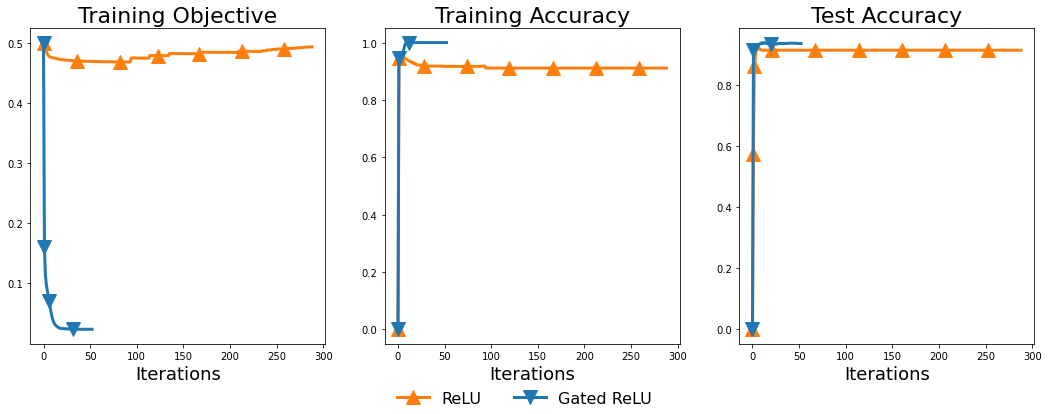

In [11]:
fig = plt.figure(figsize=(18,6))
spec = fig.add_gridspec(ncols=3, nrows=1)
ax0 = fig.add_subplot(spec[0, 0])

ax0.plot(np.arange(len(relu_metrics.objective)), 
         relu_metrics.objective, 
         label="ReLU", 
         color="#ff7f0e",
         marker="^",
         markevery=0.1,
         markersize=14,
         linewidth="3")

ax0.plot(np.arange(len(grelu_metrics.objective)), 
         grelu_metrics.objective, 
         label="Gated ReLU", 
         color="#1f77b4",
         marker="v", 
         markevery=0.1,
         markersize=14,
         linewidth="3"
        )

ax0.set_title("Training Objective", fontsize=22)
ax0.set_xlabel("Iterations", fontsize=18)

ax1 = fig.add_subplot(spec[0, 1])

ax1.plot(np.arange(len(relu_metrics.train_accuracy)), 
         relu_metrics.train_accuracy, 
         label="Relu", 
         color="#ff7f0e",
         marker="^",
         markevery=0.1,
         markersize=14,
         linewidth="3")

ax1.plot(np.arange(len(grelu_metrics.train_accuracy)), 
         grelu_metrics.train_accuracy, 
         label="Gated ReLU", 
         color="#1f77b4",
         marker="v", 
         markevery=0.1,
         markersize=14,
         linewidth="3"
        )

ax1.set_title("Training Accuracy", fontsize=22)
ax1.set_xlabel("Iterations", fontsize=18)

ax2 = fig.add_subplot(spec[0, 2])


ax2.plot(np.arange(len(relu_metrics.test_accuracy)), 
         relu_metrics.test_accuracy, 
         label="Relu", 
         color="#ff7f0e",
         marker="^",
         markevery=0.1,
         markersize=14,
         linewidth="3")

ax2.plot(np.arange(len(grelu_metrics.test_accuracy)), 
         grelu_metrics.test_accuracy, 
         label="Gated ReLU", 
         color="#1f77b4",
         marker="v", 
         markevery=0.1,
         markersize=14,
         linewidth="3"
        )

ax2.set_title("Test Accuracy", fontsize=22)
ax2.set_xlabel("Iterations", fontsize=18)
handles, labels = ax0.get_legend_handles_labels()
legend = fig.legend(
    handles=handles,
    labels=labels,
    loc="lower center",
    borderaxespad=0.1,
    fancybox=False,
    shadow=False,
    ncol=2,
    fontsize=16,
    frameon=False,
)
fig.subplots_adjust(
    bottom=0.15,
)

In [12]:
# Super-fast least-squares solver.
model = ConvexGatedReLU(G)
solver = LeastSquaresSolver(model, tol=1e-8)
regularizer = L2(0.01)
lstsq_model, lstsq_metrics = optimize_model(
    model,
    solver,
    metrics,
    X_train, 
    y_train, 
    X_test, 
    y_test,
    regularizer=regularizer,
    verbose=True,
)

INFO:convex_nn:Pre-Training Metrics: Train Set objective: 0.5, Train Set grad_norm: 0.09645780175924301, Train Set base_objective: 0.5, Train Set accuracy: 0.0, Train Set nc_squared_error: 0.5, Test Set nc_accuracy: 0.0, Test Set squared_error: 0.5, group_sparsity: 1.0, 
INFO:convex_nn:Post-Training Metrics: Train Set objective: 0.10596883459402834, Train Set grad_norm: 8.607546412607804e-16, Train Set base_objective: 0.10596883459402834, Train Set accuracy: 0.999, Train Set nc_squared_error: 0.05206110324112671, Test Set nc_accuracy: 0.937, Test Set squared_error: 0.1180487650629652, group_sparsity: 0.0, 


In [13]:
# Training Accuracy
np.sum(np.sign(lstsq_model(X_train)) == y_train) / len(y_train)

0.998

In [14]:
# Solver based on CXVPY.
model = ConvexGatedReLU(G)
solver = CVXPYSolver(model, "mosek")
regularizer = NeuronGL1(0.01)
cvxpy_model, cvxpy_metrics = optimize_model(
    model,
    solver,
    metrics,
    X_train, 
    y_train, 
    X_test, 
    y_test,
    regularizer=regularizer,
    verbose=True,
)

INFO:convex_nn:Pre-Training Metrics: Train Set objective: 0.5, Train Set grad_norm: 0.00788937509059906, Train Set base_objective: 0.5, Train Set accuracy: 0.0, Train Set nc_squared_error: 0.5, Test Set nc_accuracy: 0.0, Test Set squared_error: 0.5, group_sparsity: 1.0, 


                                     CVXPY                                     
                                    v1.1.15                                    
(CVXPY) Mar 14 09:55:33 PM: Your problem has 25000 variables, 0 constraints, and 0 parameters.
(CVXPY) Mar 14 09:55:33 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 14 09:55:33 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 14 09:55:33 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 14 09:55:33 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Mar 14 09:55:33 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffin

INFO:convex_nn:Post-Training Metrics: Train Set objective: 0.45672714233398437, Train Set grad_norm: 0.0003996694867964834, Train Set base_objective: 0.45672714233398437, Train Set accuracy: 0.95, Train Set nc_squared_error: 0.2976923828125, Test Set nc_accuracy: 0.915, Test Set squared_error: 0.3295959167480469, group_sparsity: 0.0, 
